In [1]:
import pandas as pd
import sklearn
import statsmodels
import numpy as np
import matplotlib.pyplot as plt
import os

### 1. 시계열 데이터 준비

In [2]:
import warnings
warnings.filterwarnings('ignore')
# Time Series 생성

filepath = os.path.join(os.getenv('HOME'), 'aiffel/data_exp/066570.KS.csv')
stock_price = pd.read_csv(filepath, index_col='Date', parse_dates=True)
ts = stock_price['Close']
ts = np.log(ts)
ts.head()

Date
2021-09-23    11.852963
2021-09-24    11.845820
2021-09-27    11.838626
2021-09-28    11.794338
2021-09-29    11.771436
Name: Close, dtype: float64

### 2. 전처리

결측치 처리

In [3]:
ts = ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

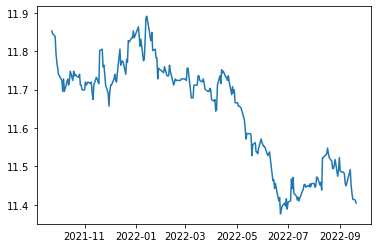

In [3]:
plt.plot(ts)
plt.show()

### 3. 시계열 안정성 분석

Augmented Dickey-Fuller Test(ADF Test)를 적용하여 시계열 데이터의 안정성을 테스트합니다. ADF Test는 주어진 시계열 데이터가 안정적이지 않다는 귀무가설을 세운 후 ADF 검정을 하고, 이 가설이 기각될 경우 주어진 시계열 데이터가 안정적이라는 대립가설을 채택하는 방법입니다.   

p-value는 귀무가설이 참이라고 가정했을 때, 표본으로 얻어지는 통계치가 나타날 확률입니다. p값이 낮으면 표본 통계량이 나타날 확률이 낮다는 이야기가 됩니다. 그러므로 p값이 0.05, 좀더 엄격히 잡으면 0.01 미만으로 매우 낮게 나올 때 p-value 만큼의 오류가능성 하에 귀무가설을 기각하고 대립가설을 채택합니다.   

이 단락에서는 시계열 데이터가 안정적이지 않다는 귀무가설에 대해 adfuller 메소드로 p-value를 구합니다. 만약 p-value가 0.05 이상으로 크다면 시계열 데이터가 불안정하다고 보고 5번 절에서 시계열 데이터를 안정시켜 분석하는 방법으로 ARIMA를 이용합니다.

또, 시계열 데이터가 안정적인지를 확인하는 다른 방법으로 시간에 따른 rolling statistics도 봅니다. rolling mean과 rolling std가 일정하게 유지되는지 그래프로 플로팅하여 관찰합니다.

In [4]:
from statsmodels.tsa.stattools import adfuller

def plot_rolling_statistics(timeseries, window=6):
    plt.figure(figsize=(8,6))
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    std = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistics', 'p-value', 
                         '#Lags Used', 'Number of Observation Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

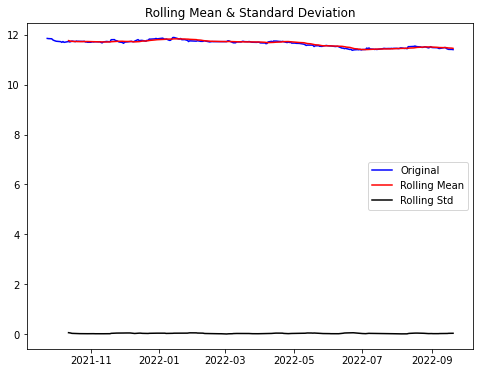

Results of Dickey-Fuller Test:
Test Statistics                -0.980217
p-value                         0.760411
#Lags Used                      1.000000
Number of Observation Used    241.000000
Critical Value (1%)            -3.457779
Critical Value (5%)            -2.873609
Critical Value (10%)           -2.573202
dtype: float64


In [5]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

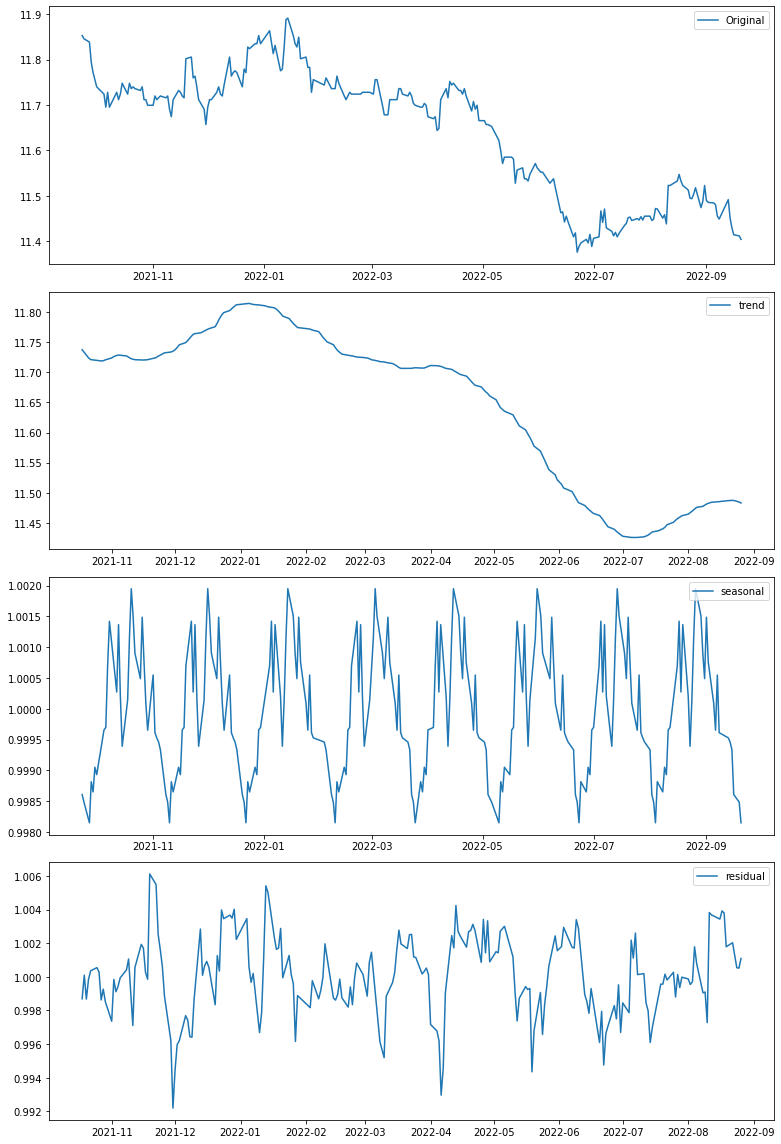

In [6]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model='multiplicative', period = 30) 

# Residual 안정성 확인

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid 

plt.figure(figsize=(11,16))
plt.subplot(411)
plt.plot(ts, label='Original')

plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='trend')

plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonal')

plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residual')

plt.legend(loc='best')
plt.tight_layout()

### 4. 학습, 테스트 데이터셋 생성

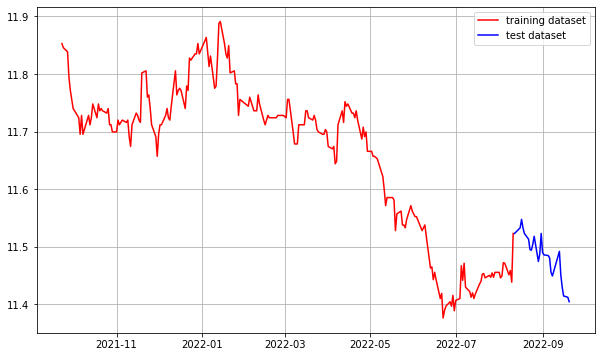

In [7]:
# 학습, 테스트 데이터셋 분리
train_len = int(len(ts)*0.9)
test_end = len(ts)
train_data, test_data = ts.iloc[:train_len], ts.iloc[train_len:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c='r', label='training dataset')  
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
plt.show()

### 5. 적정 ARIMA 모수 찾기

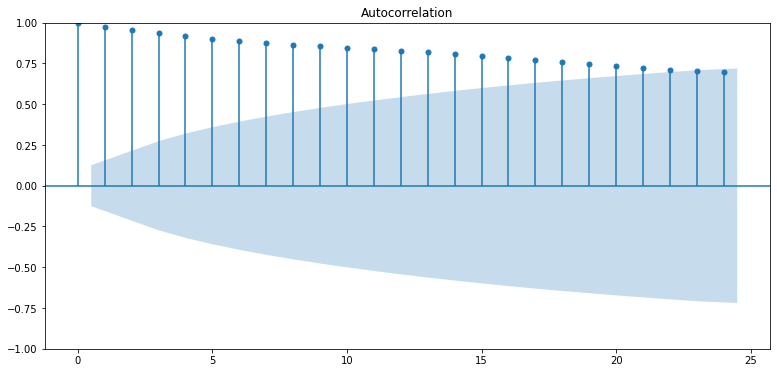

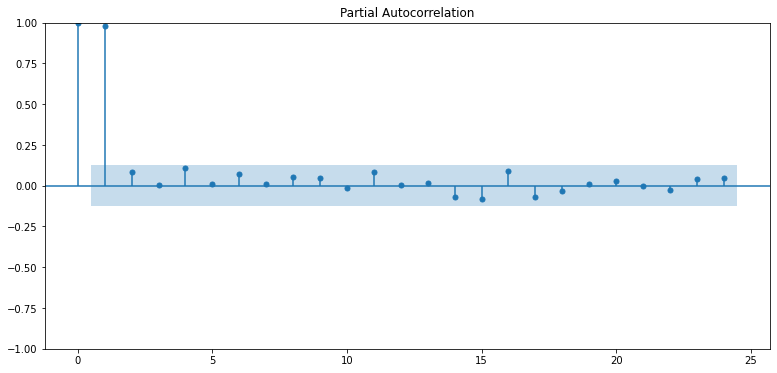

In [8]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

plot_acf(ts)
plot_pacf(ts)
plt.show()


ACF는 x가 상승함에 따라 느리게 감소합니다.   
PACF는 x=1에서 큰 관련성 수치를 보이고, 2 이상에서는 작은 수치를 보입니다.

Results of Dickey-Fuller Test:
Test Statistics              -1.756232e+01
p-value                       4.090596e-30
#Lags Used                    0.000000e+00
Number of Observation Used    2.410000e+02
Critical Value (1%)          -3.457779e+00
Critical Value (5%)          -2.873609e+00
Critical Value (10%)         -2.573202e+00
dtype: float64


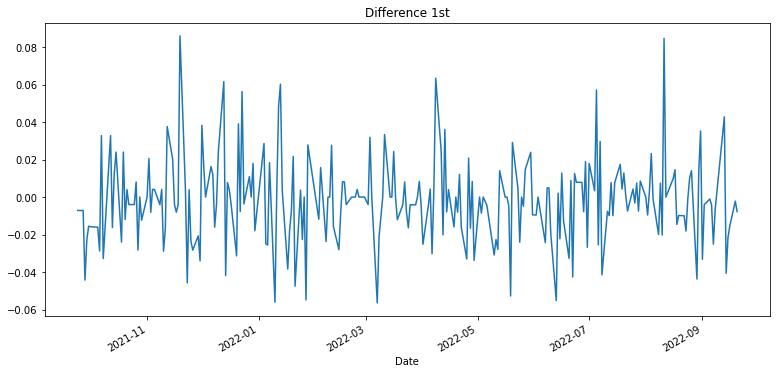

In [9]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

원래의 p-value는 0.49였고 1차 차분에서 p-value가 2e-28으로 과도하게 안정된 것으로 보입니다. 따라서 d는 0을 채택합니다.

### 6. ARIMA 모델 훈련과 테스트

In [10]:
# 모델 빌드, 훈련
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 0))
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  218
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 510.165
Date:                Tue, 20 Sep 2022   AIC                          -1012.330
Time:                        14:51:35   BIC                           -998.792
Sample:                             0   HQIC                         -1006.862
                                - 218                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6612      0.071    164.146      0.000      11.522      11.800
ar.L1          0.8698      0.070     12.367      0.000       0.732       1.008
ar.L2          0.1147      0.072      1.589      0.1

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


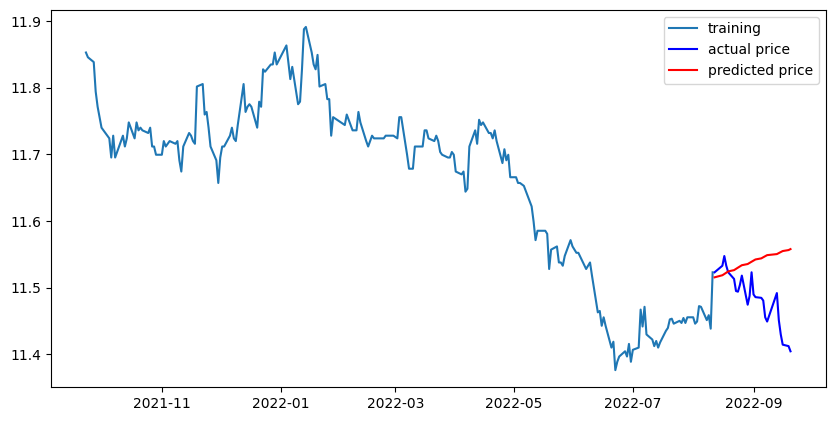

In [11]:
# 모델 테스트, 플로팅
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
fc_series = pd.Series(fc, index=test_data.index) 

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [12]:
# 최종 예측 모델 정확도 측정(MAPE)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  52479175.190701425
MAE:  5762.981715919995
RMSE:  7244.251182192776
MAPE: 6.11%


### 회고
외부 요소를 고려하지 않은 ARIMA는 주식데이터에는 잘 안맞는 모델인 것 같습니다. ARIMA가 잘 예측할 수 있는 데이터에는 어떤것들이 있는지 궁금합니다.